
# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with keras.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)
- This data goes by various name, including the "Adult" dataset and 1996 census data

In [37]:
import pandas as pd
import tensorflow as tf
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn import metrics as mt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from sklearn import metrics as mt
from tensorflow import keras
import missingno as mn
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit

df_orig = pd.read_csv('..\insurance.csv')
X_cols = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age',
         'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Y_col = 'Response'
df_orig_X = df_orig[X_cols]
df_orig_y = df_orig[Y_col]

# Split into Train and Test
We will split off 20% of the data for analisys at the end. Then for evaluating a model we will use 10-fold cross validation on the remaining 80%

In [2]:
X_train_orig_df, X_test_orig_df, y_train_orig_df, y_test_orig_df =\
    train_test_split(df_orig_X, df_orig_y, test_size=0.2, stratify=df_orig_y)

In [3]:
df_train = deepcopy(X_train_orig_df)
df_train['Repsone'] = deepcopy(y_train_orig_df)
df_test = deepcopy(X_test_orig_df)
df_test['Repsone'] = deepcopy(y_test_orig_df)

# Prepare Class Varibles

TODO: Discuss the class varibles

<AxesSubplot:>

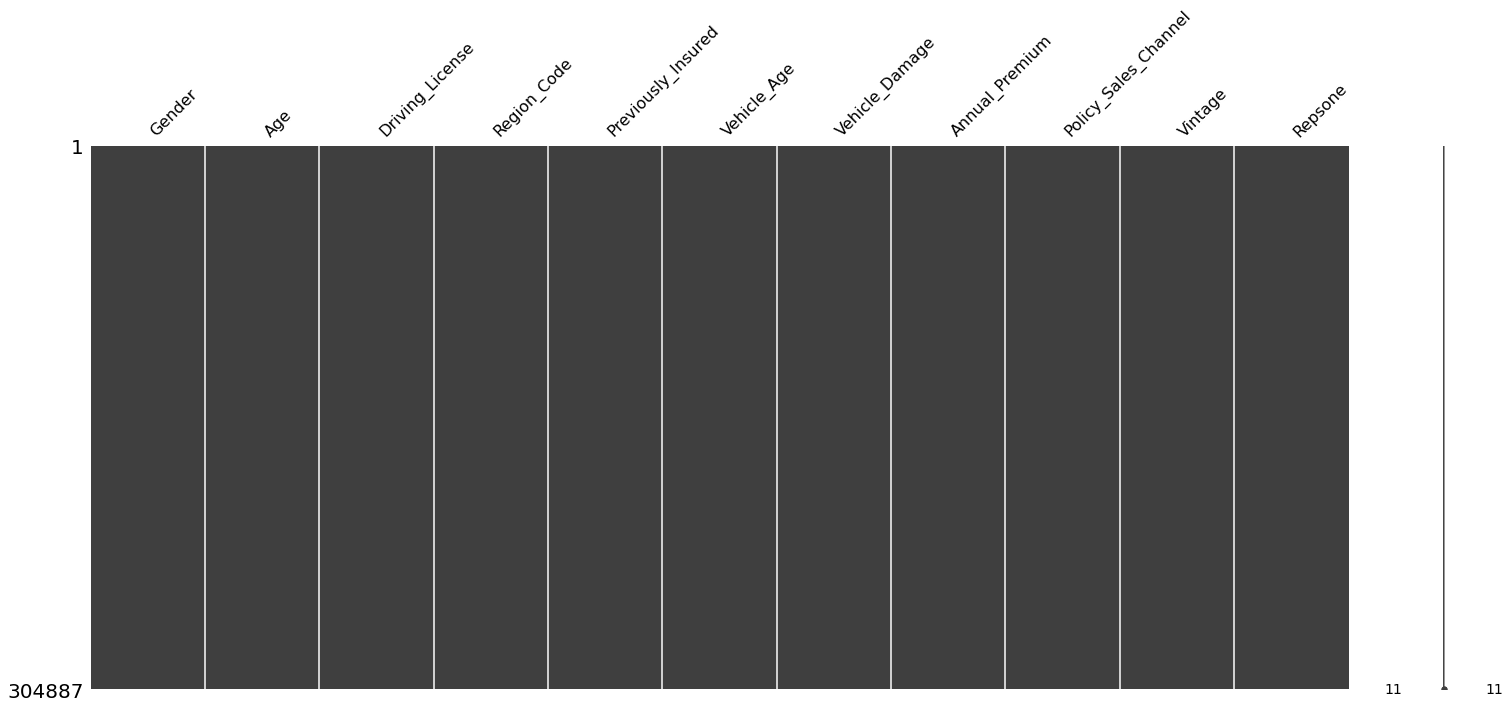

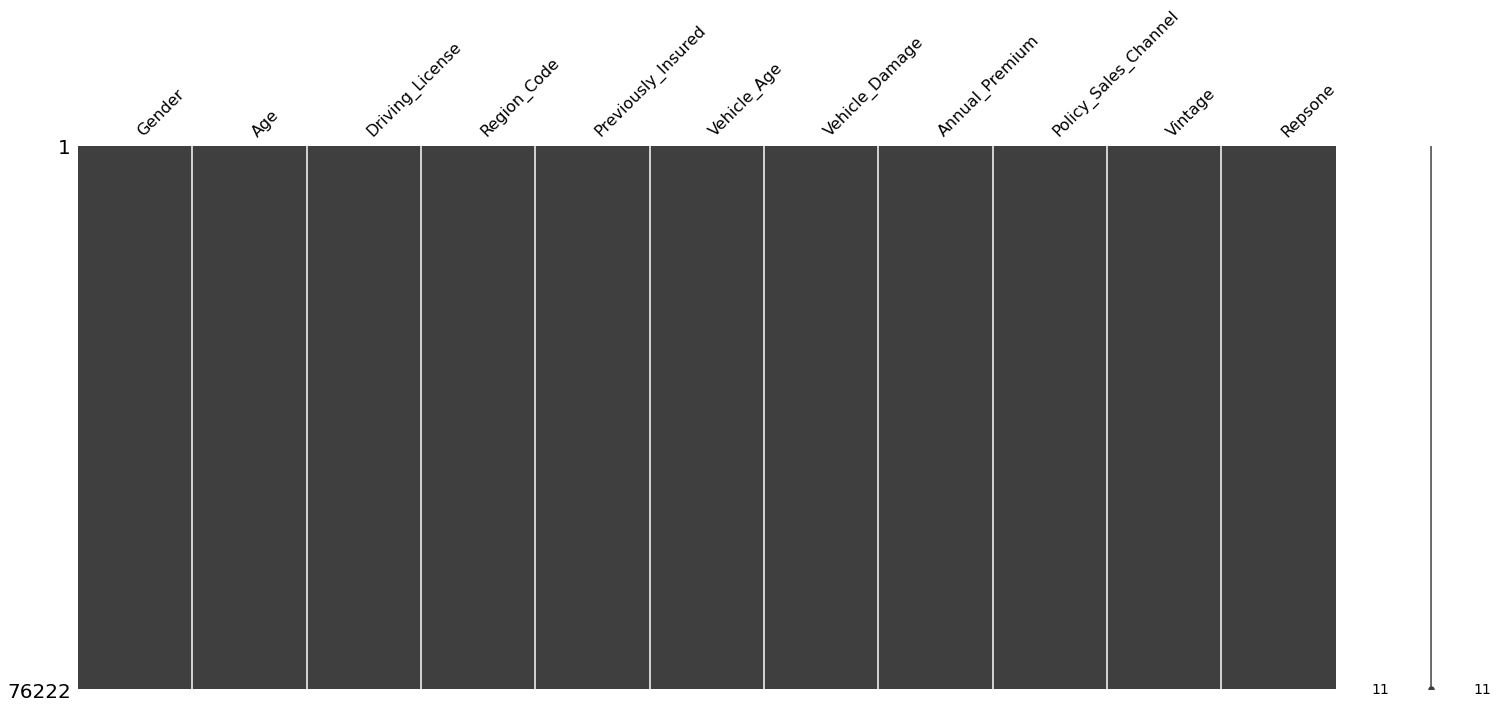

In [4]:
mn.matrix(df_train)
mn.matrix(df_test)

In [5]:
import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone
262200,Female,38,1,30.0,1,1-2 Year,No,32621.0,124.0,197,0
79436,Female,25,1,46.0,1,< 1 Year,No,2630.0,160.0,11,0
263519,Male,59,1,28.0,0,1-2 Year,Yes,32734.0,124.0,40,0
265821,Female,23,1,37.0,1,< 1 Year,Yes,37794.0,152.0,145,0
225332,Female,47,1,40.0,0,1-2 Year,Yes,2630.0,157.0,128,0


Remove Policy channels that have less than 2 samples

In [6]:
drops = []

for channel in df_test['Policy_Sales_Channel'].unique():
    if channel not in df_train['Policy_Sales_Channel'].unique():
        drops.append(channel)
drops

for drop in drops:
    print(f"Dropping {len(df_test[df_test.Policy_Sales_Channel == drop])} samples from test with {drop} Channel")
    df_test = df_test[df_test.Policy_Sales_Channel != drop]
df_test

Dropping 1 samples from test with 84.0 Channel


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone
262200,Female,38,1,30.0,1,1-2 Year,No,32621.0,124.0,197,0
79436,Female,25,1,46.0,1,< 1 Year,No,2630.0,160.0,11,0
263519,Male,59,1,28.0,0,1-2 Year,Yes,32734.0,124.0,40,0
265821,Female,23,1,37.0,1,< 1 Year,Yes,37794.0,152.0,145,0
225332,Female,47,1,40.0,0,1-2 Year,Yes,2630.0,157.0,128,0
...,...,...,...,...,...,...,...,...,...,...,...
94070,Female,66,1,3.0,0,1-2 Year,Yes,31910.0,26.0,231,1
299277,Male,53,1,28.0,0,1-2 Year,Yes,43755.0,26.0,171,0
265355,Female,22,1,45.0,0,< 1 Year,Yes,23876.0,124.0,165,1
243936,Female,26,1,27.0,1,< 1 Year,No,2630.0,152.0,160,0


# Groups of Variables

'Gender','Policy_Sales_Channel'

'Vehicle_Age','Vehicle_Damage','Previously_Insured'

'Region_Code','Gender',

                

#### Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- branches of crossed categorical features as input 
- one branch for each crossed column

In [7]:
# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['Gender','Region_Code','Previously_Insured',
                       'Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

# train all encoders (special case the target 'income')
for col in categorical_headers:
    df_train[col] = df_train[col]
    df_test[col] = df_test[col]
    
    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["Age", "Annual_Premium", "Vintage"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Repsone,Gender_int,Region_Code_int,Previously_Insured_int,Vehicle_Age_int,Vehicle_Damage_int,Policy_Sales_Channel_int
262200,Female,-0.053609,1,30.0,1,1-2 Year,No,0.119854,124.0,0.510254,0,0,30,1,0,0,118
79436,Female,-0.890831,1,46.0,1,< 1 Year,No,-1.622104,160.0,-1.711890,0,0,46,1,1,0,152
263519,Male,1.298826,1,28.0,0,1-2 Year,Yes,0.126417,124.0,-1.365427,0,1,28,0,0,1,118
265821,Female,-1.019634,1,37.0,1,< 1 Year,Yes,0.420315,152.0,-0.110990,0,0,37,1,1,1,144
225332,Female,0.526006,1,40.0,0,1-2 Year,Yes,-1.622104,157.0,-0.314090,0,0,40,0,0,1,149


In [8]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]

feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['Repsone'].values.astype(np.int)
y_test = df_test['Repsone'].values.astype(np.int)


In [9]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

In [10]:
# possible crossing options:
#   'workclass','education','marital_status',
#   'occupation','relationship','race',
#   'sex','country'

cross_columns = [
                ['Gender','Policy_Sales_Channel'],
                ['Vehicle_Age','Vehicle_Damage','Previously_Insured'],
                ['Region_Code','Gender',]
                ]
                

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(str(x)), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    

# Metric (touch this up a lot)
The Most important metric to us is Recall. We want to make sure any customer that is possible to bite on a deal is offered something

# Modeling
## Model 1

In [19]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model_1 = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)



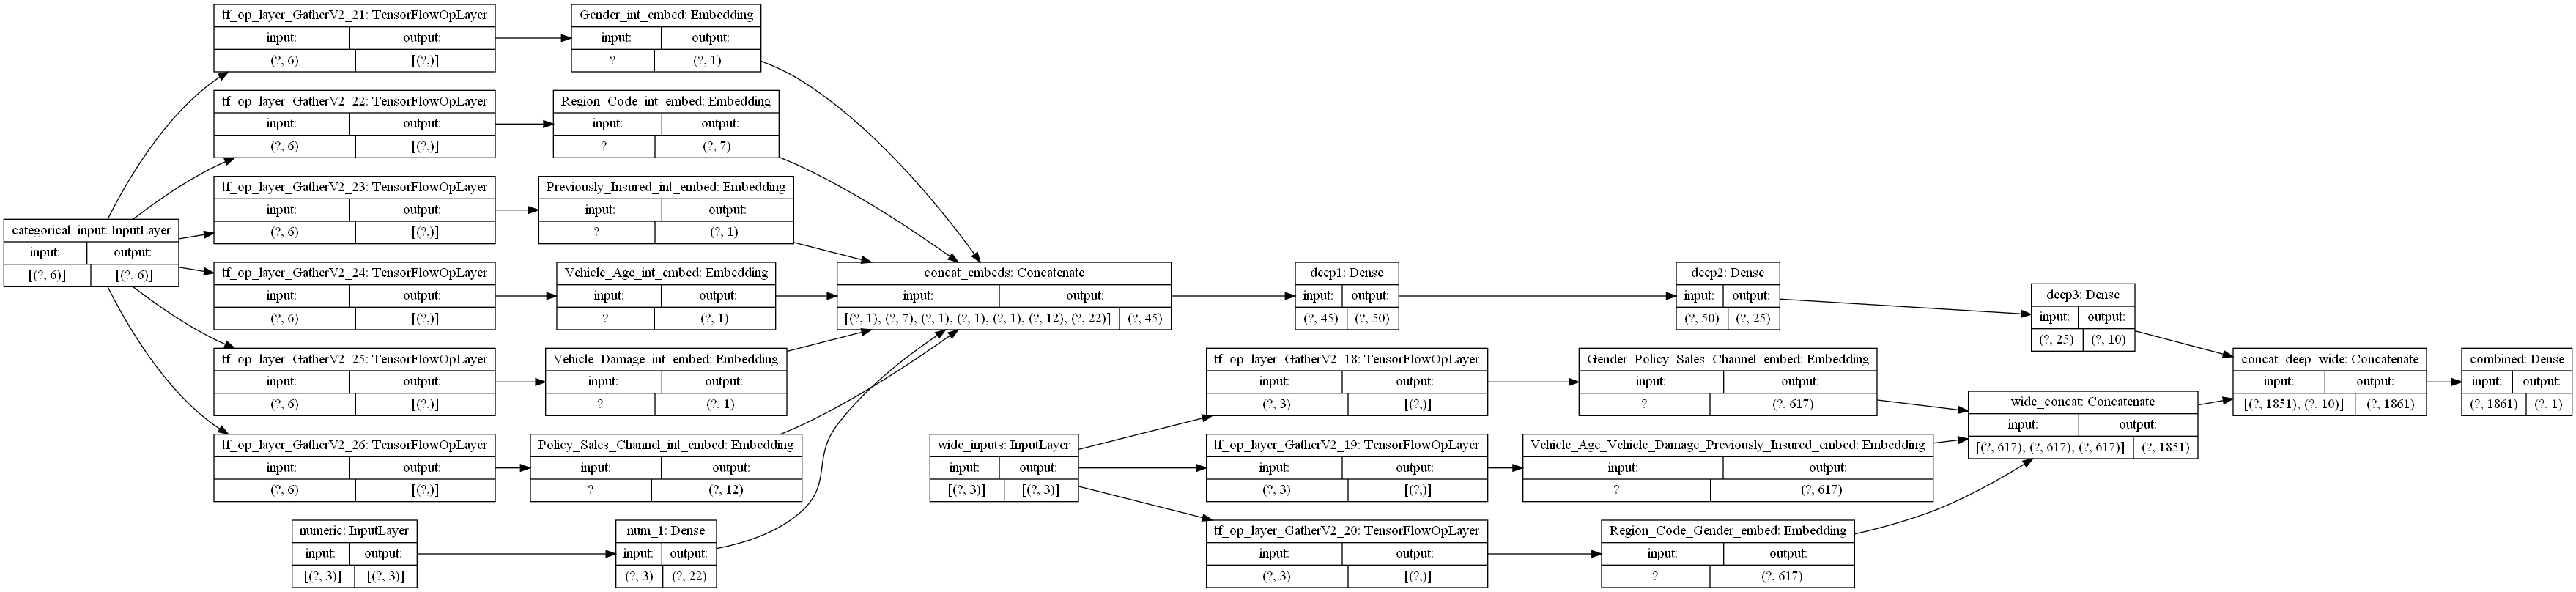

In [20]:
from tensorflow.keras.utils import plot_model

# you will need to install pydot properly on your machine to get this running
plot_model(
    model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [21]:
%%time

model_1.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy',tf.keras.metrics.Recall()])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress

c_0 = np.count_nonzero(y_train)
c_1 = len(y_train) - c_0
w_0 = c_0 / (c_1 + c_0)
w_1 = c_1 / (c_1 + c_0)

weights = {0: w_0, 1: w_1}
history = model_1.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=40, 
                    batch_size=100, 
                    verbose=1, class_weight=weights,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.0538 - accuracy: 0.5133 - recall_2: 0.4845 - val_loss: 0.2496 - val_accuracy: 0.5192 - val_recall_2: 0.4826
Epoch 2/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.0538 - accuracy: 0.5266 - recall_2: 0.4725 - val_loss: 0.2493 - val_accuracy: 0.5336 - val_recall_2: 0.4705
Epoch 3/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.0538 - accuracy: 0.5416 - recall_2: 0.4579 - val_loss: 0.2489 - val_accuracy: 0.5471 - val_recall_2: 0.4577
Epoch 4/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.0537 - accuracy: 0.5550 - recall_2: 0.4476 - val_loss: 0.2486 - val_accuracy: 0.5598 - val_recall_2: 0.4470
Epoch 5/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.0537 - accuracy: 0.5665 - recall_2: 0.4380 - val_loss: 0.2482 - val_accuracy: 0.5721 - val_recall_2: 0.4360
Epoch 6/40
3049/3049 [==============================] - 7s 2ms/step - 

In [24]:
# you will need to install pydot properly on your machine to get this running
#plot_model(
#    model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
#    rankdir='LR', expand_nested=False, dpi=96
#)
#model_1.summary()

In [26]:
yhat = np.round(model_1.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

[[45273 21606]
 [ 1276  8066]]
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     66879
           1       0.27      0.86      0.41      9342

    accuracy                           0.70     76221
   macro avg       0.62      0.77      0.61     76221
weighted avg       0.89      0.70      0.75     76221



Text(0.5, 0, 'epochs')

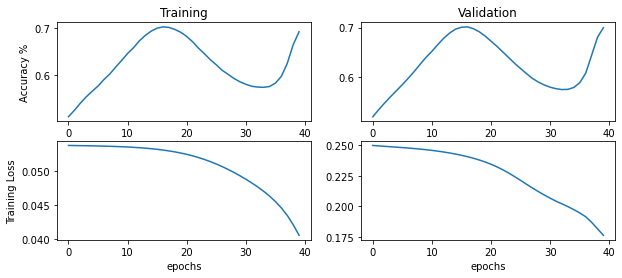

In [27]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## Model 1 with 10-Fold

In [41]:
clf = Pipeline([('NN', Model(inputs=[input_crossed,input_cat,input_num], 
                      outputs=final_branch))])
#https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
cv = StratifiedKFold(n_splits=10, shuffle=True)
my_scorer = make_scorer(recall_score)

for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
    print(f"Training on fold {index+1} + /10...")



Training on fold 1 + /10...
Training on fold 2 + /10...
Training on fold 3 + /10...
Training on fold 4 + /10...
Training on fold 5 + /10...
Training on fold 6 + /10...
Training on fold 7 + /10...
Training on fold 8 + /10...
Training on fold 9 + /10...
Training on fold 10 + /10...
